### Setup

In [18]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
import torchvision
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F

# Latent dimensions
latent_dim = 10
# Training iterations
iter_max = 50
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [3]:
def get_mnist_data(device, batch_size):
    preprocess = torchvision.transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=True, download=True, transform=preprocess), batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=False, download=True, transform=preprocess), batch_size=batch_size, shuffle=True, num_workers=2)


    # Create pre-processed training and test sets
    X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_train = train_loader.dataset.train_labels.to(device)
    X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    y_test = test_loader.dataset.test_labels.to(device)
    # print(test_loader.dataset.test_data.size())

    # return train_loader, (X_test, y_test)
    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)
train_loader

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


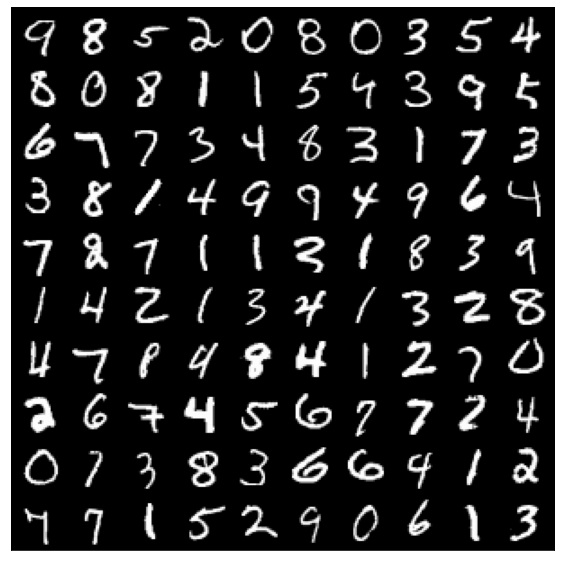

In [33]:
from matplotlib import pyplot as plt

def imshow(img):
    npimg = img.numpy()
    # print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(npimg)
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images, nrow = 10))

### Utility Functions

In [5]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    std = torch.exp(0.5 * torch.log(v))
    eps = torch.randn_like(std)
    z = m + std*eps

    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

### Base Models

In [6]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


### VAE Model

In [8]:
class VAE(nn.Module):
    def __init__(self, name = 'vae', z_dim = 2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim
        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)


    def loss(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """

        #Forward pass
        m, v = self.enc.encode(x.view(-1, 784))
        z = sample_gaussian(m, v)
        x_r = self.dec.decode(z)

        #KL
        kl = -0.5 * torch.sum(1 + torch.log(v) - m.pow(2) - torch.log(v).exp())

        #Rec
        rec = torch.sum(log_bernoulli_with_logits(x.view(-1, 784), x_r))

        nelbo = 0.01 * ((kl * beta) + rec)
        return nelbo, kl, rec

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


# Training with β = 1:

In [19]:
#setting beta value
beta = 1

vae = VAE(z_dim = latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

train_loss1 = []
kl_arr1 = []
rec_arr1 = []

for i in tqdm(range(iter_max)):
  vae.train()
  for batch_idx, (xu, _) in enumerate(train_loader):
      xu = xu.to(device)
      optimizer.zero_grad()

      loss, kl, rec = vae.loss(xu)
      loss.backward()
      optimizer.step()

  print('Train set loss:{}'.format(loss))
  train_loss1 = np.append(train_loss1, loss.item())
  kl_arr1 = np.append(kl_arr1, kl.item())
  rec_arr1 = np.append(rec_arr1 , rec.item())

  2%|▏         | 1/50 [00:18<14:44, 18.05s/it]

Train set loss:128.96343994140625


  4%|▍         | 2/50 [00:35<14:21, 17.94s/it]

Train set loss:122.92765045166016


  6%|▌         | 3/50 [00:54<14:14, 18.18s/it]

Train set loss:110.4962387084961


  8%|▊         | 4/50 [01:12<13:52, 18.10s/it]

Train set loss:114.5245590209961


 10%|█         | 5/50 [01:32<14:09, 18.88s/it]

Train set loss:113.13114166259766


 12%|█▏        | 6/50 [01:51<13:56, 19.01s/it]

Train set loss:104.17108917236328


 14%|█▍        | 7/50 [02:10<13:26, 18.77s/it]

Train set loss:108.97006225585938


 16%|█▌        | 8/50 [02:28<13:03, 18.64s/it]

Train set loss:105.85554504394531


 18%|█▊        | 9/50 [02:46<12:36, 18.46s/it]

Train set loss:102.4440689086914


 20%|██        | 10/50 [03:04<12:11, 18.28s/it]

Train set loss:108.81840515136719


 22%|██▏       | 11/50 [03:22<11:48, 18.18s/it]

Train set loss:104.76640319824219


 24%|██▍       | 12/50 [03:40<11:28, 18.12s/it]

Train set loss:108.2020492553711


 26%|██▌       | 13/50 [03:58<11:07, 18.05s/it]

Train set loss:108.32938385009766


 28%|██▊       | 14/50 [04:16<10:51, 18.08s/it]

Train set loss:105.42700958251953


 30%|███       | 15/50 [04:35<10:38, 18.25s/it]

Train set loss:107.04946899414062


 32%|███▏      | 16/50 [04:53<10:18, 18.19s/it]

Train set loss:101.323974609375


 34%|███▍      | 17/50 [05:11<09:59, 18.16s/it]

Train set loss:102.74059295654297


 36%|███▌      | 18/50 [05:29<09:38, 18.07s/it]

Train set loss:101.66804504394531


 38%|███▊      | 19/50 [05:47<09:23, 18.17s/it]

Train set loss:101.61173248291016


 40%|████      | 20/50 [06:05<09:02, 18.09s/it]

Train set loss:98.872314453125


 42%|████▏     | 21/50 [06:24<08:51, 18.32s/it]

Train set loss:101.95121765136719


 44%|████▍     | 22/50 [06:42<08:33, 18.35s/it]

Train set loss:103.08499145507812


 46%|████▌     | 23/50 [07:01<08:22, 18.63s/it]

Train set loss:100.47416687011719


 48%|████▊     | 24/50 [07:21<08:14, 19.02s/it]

Train set loss:99.9588623046875


 50%|█████     | 25/50 [07:40<07:50, 18.82s/it]

Train set loss:101.23424530029297


 52%|█████▏    | 26/50 [07:58<07:25, 18.57s/it]

Train set loss:101.5765609741211


 54%|█████▍    | 27/50 [08:16<07:02, 18.36s/it]

Train set loss:104.67694091796875


 56%|█████▌    | 28/50 [08:34<06:42, 18.28s/it]

Train set loss:96.87136840820312


 58%|█████▊    | 29/50 [08:52<06:25, 18.36s/it]

Train set loss:103.63406372070312


 60%|██████    | 30/50 [09:10<06:05, 18.27s/it]

Train set loss:98.13410949707031


 62%|██████▏   | 31/50 [09:28<05:44, 18.14s/it]

Train set loss:98.46356964111328


 64%|██████▍   | 32/50 [09:46<05:24, 18.05s/it]

Train set loss:99.76773071289062


 66%|██████▌   | 33/50 [10:04<05:05, 17.99s/it]

Train set loss:102.89412689208984


 68%|██████▊   | 34/50 [10:22<04:48, 18.01s/it]

Train set loss:101.93336486816406


 70%|███████   | 35/50 [10:40<04:31, 18.10s/it]

Train set loss:100.65989685058594


 72%|███████▏  | 36/50 [10:58<04:13, 18.13s/it]

Train set loss:102.02033996582031


 74%|███████▍  | 37/50 [11:16<03:54, 18.01s/it]

Train set loss:100.20317840576172


 76%|███████▌  | 38/50 [11:34<03:36, 18.01s/it]

Train set loss:104.42547607421875


 78%|███████▊  | 39/50 [11:52<03:18, 18.04s/it]

Train set loss:98.98881530761719


 80%|████████  | 40/50 [12:10<02:59, 17.97s/it]

Train set loss:99.04911804199219


 82%|████████▏ | 41/50 [12:31<02:48, 18.76s/it]

Train set loss:103.3585433959961


 84%|████████▍ | 42/50 [12:49<02:28, 18.61s/it]

Train set loss:99.83714294433594


 86%|████████▌ | 43/50 [13:07<02:08, 18.42s/it]

Train set loss:96.0214614868164


 88%|████████▊ | 44/50 [13:25<01:50, 18.37s/it]

Train set loss:95.64405059814453


 90%|█████████ | 45/50 [13:43<01:31, 18.30s/it]

Train set loss:99.4140396118164


 92%|█████████▏| 46/50 [14:01<01:12, 18.24s/it]

Train set loss:99.75927734375


 94%|█████████▍| 47/50 [14:20<00:55, 18.49s/it]

Train set loss:103.03690338134766


 96%|█████████▌| 48/50 [14:39<00:36, 18.49s/it]

Train set loss:97.21080017089844


 98%|█████████▊| 49/50 [14:57<00:18, 18.38s/it]

Train set loss:95.26461029052734


100%|██████████| 50/50 [15:15<00:00, 18.32s/it]

Train set loss:100.35750579833984


# Statistics:

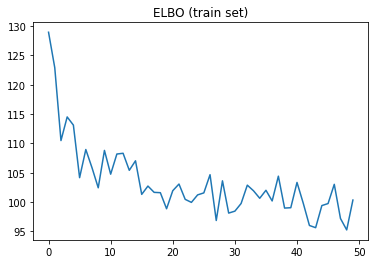

In [27]:
plt.plot(train_loss1)
plt.title('ELBO (train set)')
plt.show()

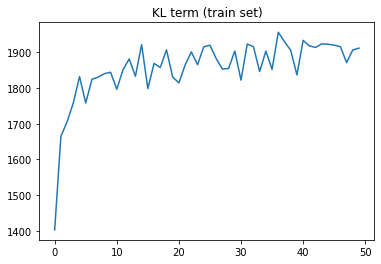

In [28]:
plt.plot(kl_arr1)
plt.title('KL term (train set)')
plt.show()

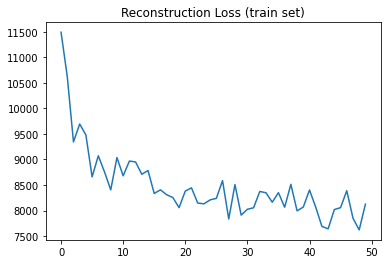

In [29]:
plt.plot(rec_arr1)
plt.title('Reconstruction Loss (train set)')
plt.show()

# Reconstructing 100 Numbers (β =1):

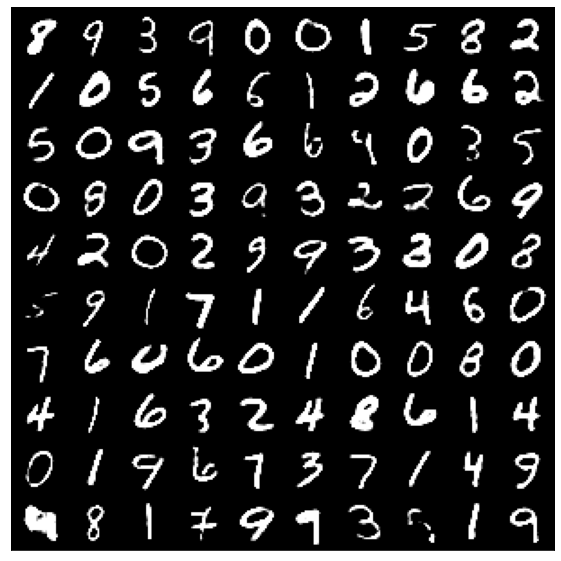

In [69]:
import random

###############################################################
# 100 numbers that we will reconstrust for all 3 values of beta
# will be saved in this tensor
rec_batch = torch.zeros(0)
###############################################################

with torch.no_grad():
  for batch_idx, (xu, _) in enumerate(random.sample(list(train_loader), 1)):
    rec_batch = xu.to(device)
    m, v = vae.enc.encode(rec_batch.view(-1, 784))
    z = sample_gaussian(m, v).to(device)
    sample = vae.dec.decode(z).to(device)

    imshow(torchvision.utils.make_grid(sample.view(100, 1, 28, 28),nrow=10))

# Generating 100 Numbers (β =1):

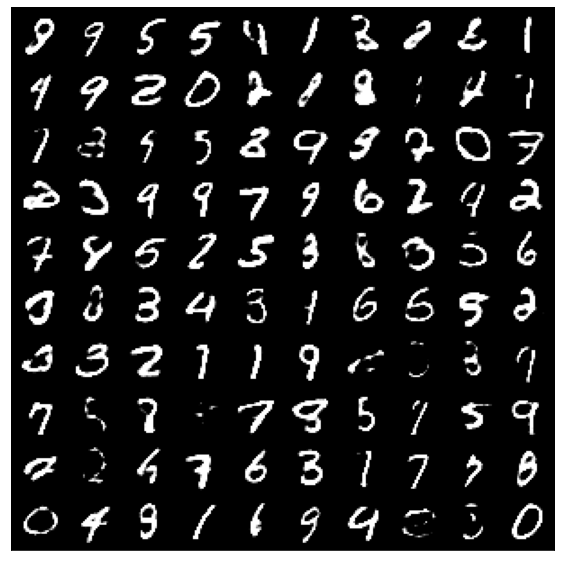

In [42]:
with torch.no_grad():
    z = torch.randn(100, 10).to(device)
    sample = vae.dec.decode(z).to(device)

    imshow(torchvision.utils.make_grid(sample.view(100, 1, 28, 28),nrow=10))

# Training with β < 1 ( β = 0.35 ):

In [74]:
#changing beta value from 1 to 0.35
beta = 0.35

vae2 = VAE(z_dim = latent_dim).to(device)
optimizer = optim.Adam(vae2.parameters(), lr=learning_rate)

train_loss2 = []
kl_arr2 = []
rec_arr2 = []

for i in tqdm(range(iter_max)):
  vae2.train()
  for batch_idx, (xu, _) in enumerate(train_loader):
      xu = xu.to(device)
      optimizer.zero_grad()

      loss, kl, rec = vae2.loss(xu)
      loss.backward()
      optimizer.step()

  print('Train set loss:{}'.format(loss))
  train_loss2 = np.append(train_loss2 ,loss.item())
  kl_arr2 = np.append(kl_arr2 , kl.item())
  rec_arr2 = np.append(rec_arr2 , rec.item())

  2%|▏         | 1/50 [00:20<16:27, 20.15s/it]

Train set loss:107.3284912109375


  4%|▍         | 2/50 [00:40<16:14, 20.30s/it]

Train set loss:102.80301666259766


  6%|▌         | 3/50 [01:00<15:40, 20.01s/it]

Train set loss:98.58992767333984


  8%|▊         | 4/50 [01:19<15:05, 19.67s/it]

Train set loss:95.11674499511719


 10%|█         | 5/50 [01:38<14:38, 19.53s/it]

Train set loss:91.55848693847656


 12%|█▏        | 6/50 [01:58<14:21, 19.58s/it]

Train set loss:99.28142547607422


 14%|█▍        | 7/50 [02:17<14:01, 19.56s/it]

Train set loss:91.25701904296875


 16%|█▌        | 8/50 [02:37<13:47, 19.71s/it]

Train set loss:88.205810546875


 18%|█▊        | 9/50 [03:00<13:59, 20.49s/it]

Train set loss:93.17011260986328


 20%|██        | 10/50 [03:19<13:23, 20.10s/it]

Train set loss:94.07160186767578


 22%|██▏       | 11/50 [03:38<12:50, 19.75s/it]

Train set loss:92.44386291503906


 24%|██▍       | 12/50 [03:57<12:23, 19.57s/it]

Train set loss:91.06968688964844


 26%|██▌       | 13/50 [04:16<12:00, 19.48s/it]

Train set loss:88.23612213134766


 28%|██▊       | 14/50 [04:36<11:40, 19.47s/it]

Train set loss:89.24769592285156


 30%|███       | 15/50 [04:55<11:25, 19.58s/it]

Train set loss:92.59365844726562


 32%|███▏      | 16/50 [05:14<10:59, 19.40s/it]

Train set loss:91.08128356933594


 34%|███▍      | 17/50 [05:33<10:35, 19.27s/it]

Train set loss:85.88003540039062


 36%|███▌      | 18/50 [05:53<10:16, 19.26s/it]

Train set loss:88.80913543701172


 38%|███▊      | 19/50 [06:12<09:57, 19.28s/it]

Train set loss:91.01638793945312


 40%|████      | 20/50 [06:31<09:37, 19.27s/it]

Train set loss:82.24292755126953


 42%|████▏     | 21/50 [06:51<09:19, 19.31s/it]

Train set loss:94.17972564697266


 44%|████▍     | 22/50 [07:10<09:00, 19.31s/it]

Train set loss:94.82550811767578


 46%|████▌     | 23/50 [07:29<08:38, 19.20s/it]

Train set loss:85.75373840332031


 48%|████▊     | 24/50 [07:52<08:45, 20.23s/it]

Train set loss:81.33103942871094


 50%|█████     | 25/50 [08:11<08:18, 19.94s/it]

Train set loss:88.61168670654297


 52%|█████▏    | 26/50 [08:30<07:52, 19.71s/it]

Train set loss:89.0060043334961


 54%|█████▍    | 27/50 [08:49<07:29, 19.52s/it]

Train set loss:89.04537200927734


 56%|█████▌    | 28/50 [09:09<07:09, 19.51s/it]

Train set loss:89.39740753173828


 58%|█████▊    | 29/50 [09:28<06:49, 19.49s/it]

Train set loss:89.82389068603516


 60%|██████    | 30/50 [09:48<06:33, 19.67s/it]

Train set loss:85.55707550048828


 62%|██████▏   | 31/50 [10:08<06:14, 19.72s/it]

Train set loss:81.89344024658203


 64%|██████▍   | 32/50 [10:27<05:52, 19.57s/it]

Train set loss:83.46910858154297


 66%|██████▌   | 33/50 [10:46<05:30, 19.45s/it]

Train set loss:86.2503433227539


 68%|██████▊   | 34/50 [11:05<05:09, 19.36s/it]

Train set loss:87.13777160644531


 70%|███████   | 35/50 [11:24<04:49, 19.27s/it]

Train set loss:88.76039123535156


 72%|███████▏  | 36/50 [11:44<04:28, 19.21s/it]

Train set loss:87.6104965209961


 74%|███████▍  | 37/50 [12:03<04:11, 19.33s/it]

Train set loss:85.67314147949219


 76%|███████▌  | 38/50 [12:23<03:52, 19.39s/it]

Train set loss:85.1813735961914


 78%|███████▊  | 39/50 [12:45<03:42, 20.24s/it]

Train set loss:81.36860656738281


 80%|████████  | 40/50 [13:04<03:19, 19.99s/it]

Train set loss:85.190673828125


 82%|████████▏ | 41/50 [13:23<02:57, 19.71s/it]

Train set loss:87.76810455322266


 84%|████████▍ | 42/50 [13:43<02:36, 19.61s/it]

Train set loss:88.4053726196289


 86%|████████▌ | 43/50 [14:03<02:18, 19.72s/it]

Train set loss:83.20549774169922


 88%|████████▊ | 44/50 [14:22<01:57, 19.61s/it]

Train set loss:82.7449951171875


 90%|█████████ | 45/50 [14:42<01:37, 19.60s/it]

Train set loss:82.75814056396484


 92%|█████████▏| 46/50 [15:01<01:18, 19.57s/it]

Train set loss:86.78712463378906


 94%|█████████▍| 47/50 [15:21<00:58, 19.54s/it]

Train set loss:86.6902847290039


 96%|█████████▌| 48/50 [15:40<00:38, 19.48s/it]

Train set loss:86.07927703857422


 98%|█████████▊| 49/50 [16:00<00:19, 19.50s/it]

Train set loss:87.8155288696289


100%|██████████| 50/50 [16:19<00:00, 19.59s/it]

Train set loss:80.98832702636719


# Statistics:

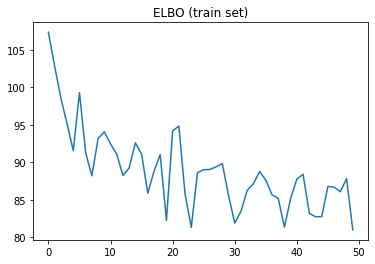

In [75]:
plt.plot(train_loss2)
plt.title('ELBO (train set)')
plt.show()

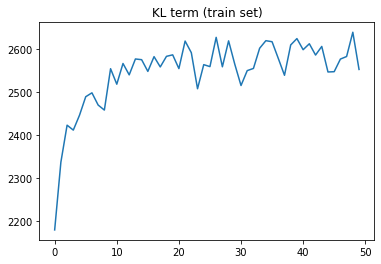

In [76]:
plt.plot(kl_arr2)
plt.title('KL term (train set)')
plt.show()

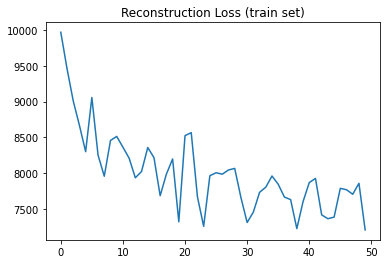

In [77]:
plt.plot(rec_arr2)
plt.title('Reconstruction Loss (train set)')
plt.show()

# Reconstructing the same 100 Numbers (β =0.35):

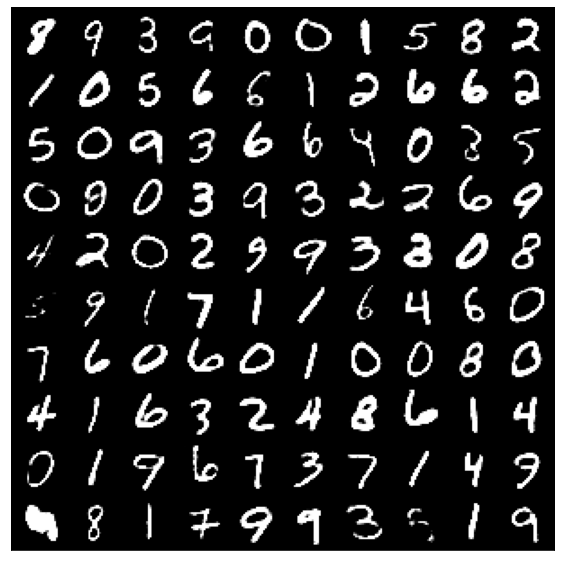

In [88]:
with torch.no_grad():
    m, v = vae2.enc.encode(rec_batch.view(-1, 784))
    z = sample_gaussian(m, v).to(device)
    sample = vae2.dec.decode(z).to(device)

    imshow(torchvision.utils.make_grid(sample.view(100, 1, 28, 28),nrow=10))

# Generating 100 Numbers (β =0.35):

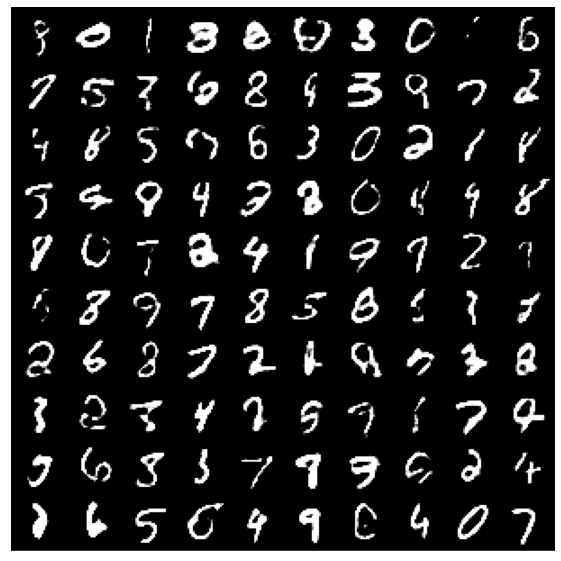

In [90]:
with torch.no_grad():
    z = torch.randn(100, 10).to(device)
    sample = vae2.dec.decode(z).to(device)

    imshow(torchvision.utils.make_grid(sample.view(100, 1, 28, 28),nrow=10))

# Training with β > 1 ( β = 5 ):

In [91]:
#changing beta value to 3
beta = 5

vae3 = VAE(z_dim = latent_dim).to(device)
optimizer = optim.Adam(vae3.parameters(), lr=learning_rate)

train_loss3 = []
kl_arr3 = []
rec_arr3 = []

for i in tqdm(range(iter_max)):
  vae3.train()
  for batch_idx, (xu, _) in enumerate(train_loader):
      xu = xu.to(device)
      optimizer.zero_grad()

      loss, kl, rec = vae3.loss(xu)
      loss.backward()
      optimizer.step()

  print('Train set loss:{}'.format(loss))
  train_loss3 = np.append(train_loss3 ,loss.item())
  kl_arr3 = np.append(kl_arr3 , kl.item())
  rec_arr3 = np.append(rec_arr3 , rec.item())

  2%|▏         | 1/50 [00:22<18:16, 22.37s/it]

Train set loss:165.6080780029297


  4%|▍         | 2/50 [00:43<17:04, 21.35s/it]

Train set loss:168.31820678710938


  6%|▌         | 3/50 [01:04<16:47, 21.44s/it]

Train set loss:156.1783905029297


  8%|▊         | 4/50 [01:25<16:20, 21.32s/it]

Train set loss:162.14825439453125


 10%|█         | 5/50 [01:45<15:39, 20.89s/it]

Train set loss:162.14749145507812


 12%|█▏        | 6/50 [02:08<15:38, 21.34s/it]

Train set loss:156.4459686279297


 14%|█▍        | 7/50 [02:27<14:46, 20.61s/it]

Train set loss:159.35086059570312


 16%|█▌        | 8/50 [02:46<14:03, 20.09s/it]

Train set loss:148.88034057617188


 18%|█▊        | 9/50 [03:09<14:22, 21.03s/it]

Train set loss:148.8511199951172


 20%|██        | 10/50 [03:36<15:20, 23.01s/it]

Train set loss:152.77281188964844


 22%|██▏       | 11/50 [03:56<14:15, 21.94s/it]

Train set loss:157.1823272705078


 24%|██▍       | 12/50 [04:16<13:37, 21.51s/it]

Train set loss:153.9113006591797


 26%|██▌       | 13/50 [04:36<12:53, 20.90s/it]

Train set loss:153.166748046875


 28%|██▊       | 14/50 [04:58<12:50, 21.39s/it]

Train set loss:157.0399169921875


 30%|███       | 15/50 [05:18<12:08, 20.82s/it]

Train set loss:153.06886291503906


 32%|███▏      | 16/50 [05:37<11:37, 20.50s/it]

Train set loss:150.88458251953125


 34%|███▍      | 17/50 [05:57<11:08, 20.26s/it]

Train set loss:160.85208129882812


 36%|███▌      | 18/50 [06:16<10:36, 19.90s/it]

Train set loss:159.19497680664062


 38%|███▊      | 19/50 [06:35<10:05, 19.54s/it]

Train set loss:148.82174682617188


 40%|████      | 20/50 [06:54<09:40, 19.36s/it]

Train set loss:156.46115112304688


 42%|████▏     | 21/50 [07:14<09:24, 19.46s/it]

Train set loss:153.06536865234375


 44%|████▍     | 22/50 [07:33<09:00, 19.32s/it]

Train set loss:149.1898956298828


 46%|████▌     | 23/50 [07:51<08:35, 19.10s/it]

Train set loss:160.72250366210938


 48%|████▊     | 24/50 [08:10<08:13, 19.00s/it]

Train set loss:151.10389709472656


 50%|█████     | 25/50 [08:29<07:52, 18.88s/it]

Train set loss:151.48886108398438


 52%|█████▏    | 26/50 [08:48<07:34, 18.94s/it]

Train set loss:154.96395874023438


 54%|█████▍    | 27/50 [09:07<07:15, 18.94s/it]

Train set loss:157.29522705078125


 56%|█████▌    | 28/50 [09:29<07:17, 19.88s/it]

Train set loss:154.65618896484375


 58%|█████▊    | 29/50 [09:47<06:50, 19.55s/it]

Train set loss:148.8717498779297


 60%|██████    | 30/50 [10:07<06:28, 19.42s/it]

Train set loss:153.432861328125


 62%|██████▏   | 31/50 [10:26<06:09, 19.45s/it]

Train set loss:150.5990447998047


 64%|██████▍   | 32/50 [10:45<05:49, 19.40s/it]

Train set loss:155.65652465820312


 66%|██████▌   | 33/50 [11:04<05:26, 19.18s/it]

Train set loss:150.1218719482422


 68%|██████▊   | 34/50 [11:23<05:06, 19.14s/it]

Train set loss:149.02279663085938


 70%|███████   | 35/50 [11:42<04:45, 19.05s/it]

Train set loss:155.1264190673828


 72%|███████▏  | 36/50 [12:00<04:24, 18.91s/it]

Train set loss:158.7396697998047


 74%|███████▍  | 37/50 [12:19<04:04, 18.79s/it]

Train set loss:157.0148468017578


 76%|███████▌  | 38/50 [12:38<03:46, 18.84s/it]

Train set loss:149.25074768066406


 78%|███████▊  | 39/50 [12:57<03:27, 18.84s/it]

Train set loss:149.55108642578125


 80%|████████  | 40/50 [13:16<03:08, 18.83s/it]

Train set loss:157.50526428222656


 82%|████████▏ | 41/50 [13:34<02:48, 18.75s/it]

Train set loss:149.64047241210938


 84%|████████▍ | 42/50 [13:53<02:29, 18.67s/it]

Train set loss:144.75546264648438


 86%|████████▌ | 43/50 [14:14<02:16, 19.46s/it]

Train set loss:152.5676727294922


 88%|████████▊ | 44/50 [14:32<01:55, 19.18s/it]

Train set loss:149.70846557617188


 90%|█████████ | 45/50 [14:51<01:35, 19.04s/it]

Train set loss:153.7007598876953


 92%|█████████▏| 46/50 [15:10<01:15, 18.92s/it]

Train set loss:154.31646728515625


 94%|█████████▍| 47/50 [15:28<00:56, 18.75s/it]

Train set loss:150.44435119628906


 96%|█████████▌| 48/50 [15:47<00:37, 18.71s/it]

Train set loss:150.66339111328125


 98%|█████████▊| 49/50 [16:06<00:18, 18.76s/it]

Train set loss:153.22987365722656


100%|██████████| 50/50 [16:25<00:00, 19.71s/it]

Train set loss:149.359619140625


# Statistics:

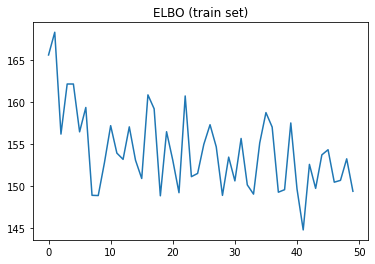

In [92]:
plt.plot(train_loss3)
plt.title('ELBO (train set)')
plt.show()

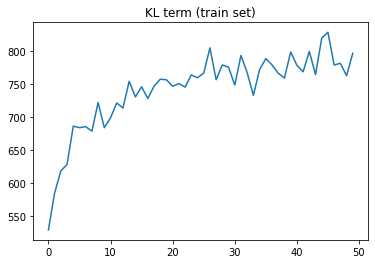

In [93]:
plt.plot(kl_arr3)
plt.title('KL term (train set)')
plt.show()

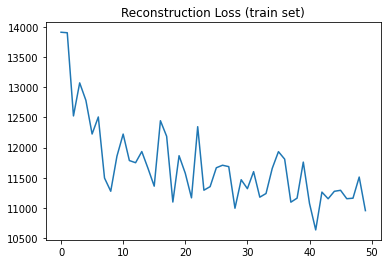

In [94]:
plt.plot(rec_arr3)
plt.title('Reconstruction Loss (train set)')
plt.show()

# Reconstructing the same 100 Numbers (β =5):

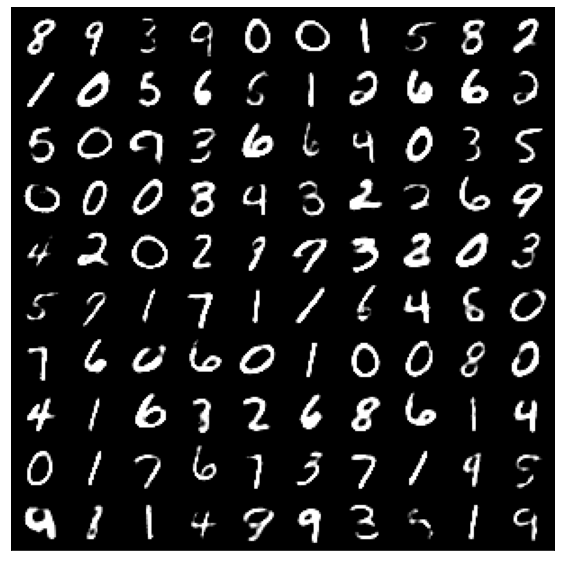

In [95]:
with torch.no_grad():
    m, v = vae3.enc.encode(rec_batch.view(-1, 784))
    z = sample_gaussian(m, v).to(device)
    sample = vae3.dec.decode(z).to(device)

    imshow(torchvision.utils.make_grid(sample.view(100, 1, 28, 28),nrow=10))

# Generating 100 Numbers (β =5):

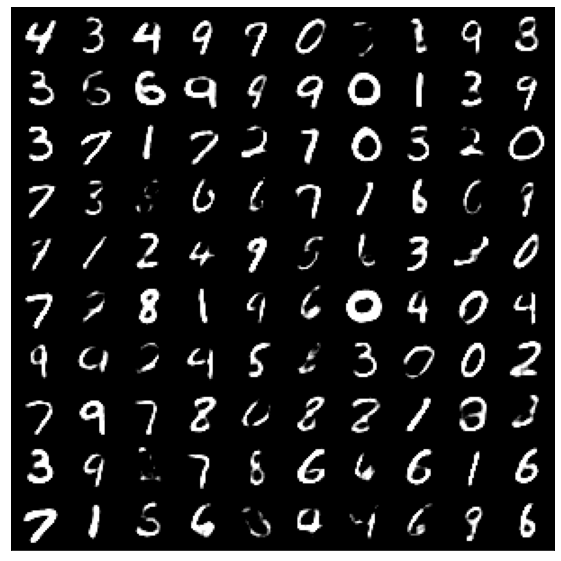

In [100]:
with torch.no_grad():
    z = torch.randn(100, 10).to(device)
    sample = vae3.dec.decode(z).to(device)

    imshow(torchvision.utils.make_grid(sample.view(100, 1, 28, 28),nrow=10))

# Changing latent dimensions one at a time:

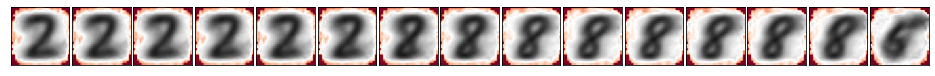

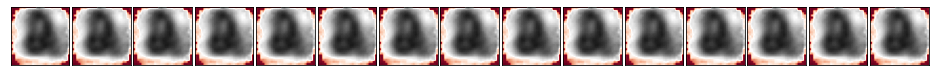

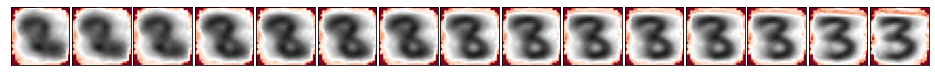

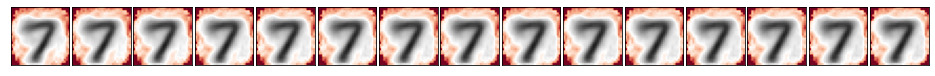

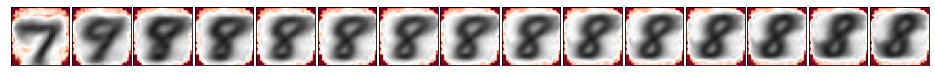

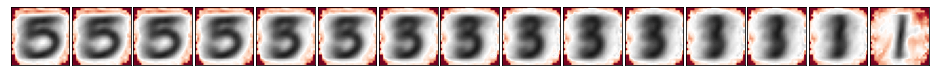

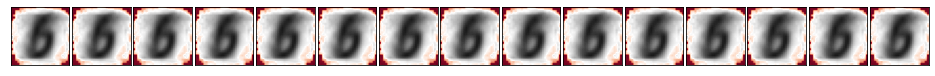

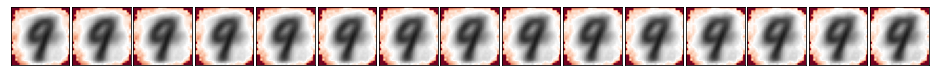

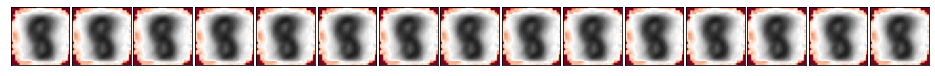

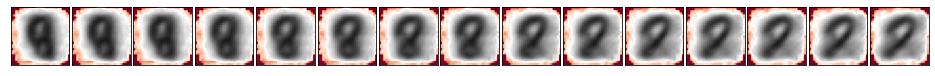

In [248]:
sample_num = 15

with torch.no_grad():
  for j in range(10):
    z = torch.randn(1, 10).to(device)
    z1, _ = torch.sort(torch.randn(sample_num))
    plt.figure(figsize=(15, 15))
    plt.grid(False)
    for i in range(sample_num):
      
      z[0,j] = z1[i].view(1,-1)
      sample = vae3.dec.decode(z).to(device)

      plt.subplot(1, sample_num, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.subplots_adjust(left=0.1,
                      bottom=0.1,
                      right=0.95,
                      top=0.95,
                      wspace=0.05,
                      hspace=0.05)
      plt.imshow(sample.reshape((28,28)), cmap = 'RdGy')
    plt.show()